Chaining: Parametric To Inversion
=================================

In this script, we chain two searches to fit `Imaging` with a strong lens model where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear`.
 - The source galaxy's `LightProfile` is an `EllExponential`.

The two searches break down as follows:

 1) Model the source galaxy using a parametric `EllSersic` and lens galaxy mass as an `EllIsothermal`.
 2) Models the source galaxy using an `Inversion` and lens galaxy mass as an `EllIsothermal`.

__Why Chain?__

There are a number of benefits of chaining a parametric source model and `Inversion`, as opposed to fitting the
`Inversion` in one search:

 - Parametric sources are computationally faster to fit. Therefore, even though the `EllSersic` has more
 parameters for the search to fit than an `Inversion`, the model-fit is faster overall.

 - `Inversion`'s often go to unphysical solutions where the mass model goes to high / low normalizations and the source
 is reconstructed as a demagnified version of the image. (see Chapter 4, tutorial 6 for a complete description of
 this effect). This does not occur for a parametric source, therefore the mass model can be initialized using a
 parametric source, which sets up the search which fits an `Inversion` so as to not sample these unphysical solutions.
      
 - The positions and positions threshold can be updated to further ensure these unphysical solutions do not bias the
 model-fit. The updated positions use the maximum log likelihood mass model of the first search to determine the
 image-plane position of the lensed source. In the second search, we then require that a mass model must trace these
 positions within a threshold arc-secoond value of one another in the source-plane, removing these unphysical solutions.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Dataset + Masking__ 

Load, plot and mask the `Imaging` data.

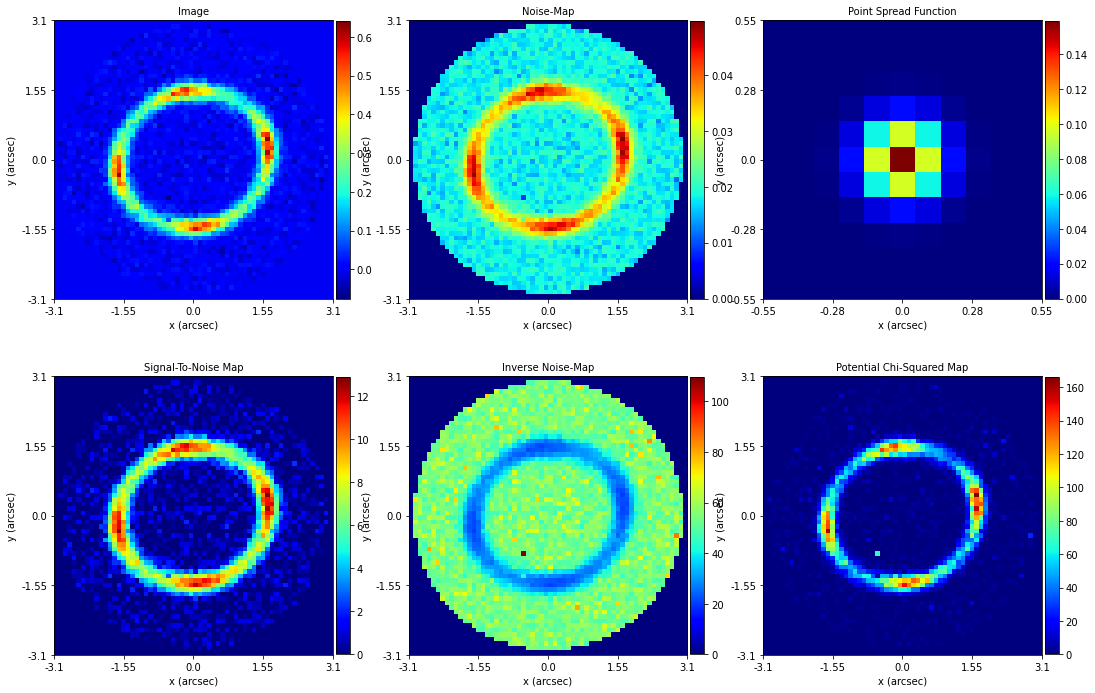

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging = imaging.apply_mask(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)

imaging_plotter.subplot_imaging()

__Paths__

The path the results of all chained searches are output:

In [3]:
path_prefix = path.join("imaging", "chaining", "parametric_to_inversion")

__Model (Search 1)__

In search 1 we fit a lens model where:

 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear` [7 parameters].
 - The source galaxy's light is a parametric `EllSersic` [7 parameters].

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=13.

In [4]:
lens = af.Model(
    al.Galaxy, redshift=0.5, mass=al.mp.EllIsothermal, shear=al.mp.ExternalShear
)
source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllSersic)

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

__Search + Analysis + Model-Fit (Search 1)__

We now create the non-linear search, analysis and perform the model-fit using this model.

You may wish to inspect the results of the search 1 model-fit to ensure a fast non-linear search has been provided that 
provides a reasonably accurate lens model.

In [5]:
search = af.DynestyStatic(
    path_prefix=path_prefix, name="search[1]__parametric", nlive=50
)

analysis = al.AnalysisImaging(dataset=imaging)

result_1 = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:390: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 10.04it/s, +50 | bound: 0 | nc: 1 | ncall: 52 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.059]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


__Model (Search 2)__

We use the results of search 1 to create the lens model fitted in search 2, where:

 - The lens galaxy's total mass distribution is again an `EllIsothermal` and `ExternalShear` [7 parameters: 
 priors initialized from search 1].
 - The source-galaxy's light uses a `VoronoiMagnification` pixelization [2 parameters].
 - This pixelization is regularized using a `Constant` scheme which smooths every source pixel equally [1 parameter]. 
 
The number of free parameters and therefore the dimensionality of non-linear parameter space is N=10.

The term `model` below passes the source model as model-components that are to be fitted for by the 
non-linear search. We pass the `lens` as a `model`, so that we can use the mass model inferred by search 1. The source
does not use any priors from the result of search 1.

In [6]:
lens = result_1.model.galaxies.lens
source = af.Model(
    al.Galaxy,
    redshift=1.0,
    pixelization=al.pix.VoronoiMagnification,
    regularization=al.reg.Constant,
)
model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

__Analysis + Positions__

In this example we update the positions between searches, where the positions correspond to the (y,x) locations of the 
lensed source's multiple images. When a model-fit uses positions, it requires them to trace within a threshold value of 
one another for every mass model sampled by the non-linear search. If they do not, the model is discarded and resampled. 

Below, we use the results of the first search to compute the lensed source positions that are input into search 2. The
code below uses the  maximum log likelihood model mass model and source galaxy centre, to determine where the source
positions are located in the image-plane. 

We also use this result to set the `position_threshold`, whereby the threshold value is based on how close these 
positions trace to one another in the source-plane (using the best-fit mass model again). This threshold is multiplied 
by a `factor` to ensure it is not too small (and thus does not remove plausible mass  models). If, after this 
multiplication, the threshold is below the `minimum_threshold`, it is rounded up to this minimum value.

In [7]:
settings_lens = al.SettingsLens(
    positions_threshold=result_1.positions_threshold_from(
        factor=3.0, minimum_threshold=0.2
    )
)

analysis = al.AnalysisImaging(
    dataset=imaging,
    positions=result_1.image_plane_multiple_image_positions,
    settings_lens=settings_lens,
)

__Search + Model-Fit__

We now create the non-linear search and perform the model-fit using this model.

In [8]:
search = af.DynestyStatic(
    path_prefix=path_prefix, name="search[2]__inversion", nlive=40
)

result_2 = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:390: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
0it [00:00, ?it/s]/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'slim_indexes' of function 'furthest_grid_2d_slim_index_from'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../PyAutoArray/autoarray/structures/grids/two_d/grid_2d_util.py", line 675:
@decorator_util.jit()
def furthest_grid_2d_slim_index_from(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
2it [00:03,  1.93s/it, +40 | bound:

__Wrap Up__

In this example, we passed used prior passing to initialize an `EllIsothermal` + `ExternalShear` lens mass model 
using a parametric source and pass this model to a second search which modeled the source using an `Inversion`. 

This was more computationally efficient than just fitting the `Inversion` by itself and helped to ensure that the 
`Inversion` did not go to an unphysical mass model solution which reconstructs the source as a demagnified version
of the lensed image.

__Pipelines__

Advanced search chaining uses `pipelines` that chain together multiple searches to perform complex lens modeling 
in a robust and efficient way. 

The following example pipelines fits an inversion, using the same approach demonstrated in this script of first fitting 
a parametric source:

 `autolens_workspace/imaging/chaining/pipelines/no_lens_light/mass_total__source_inversion.py`

 __SLaM (Source, Light and Mass)__
 
An even more advanced approach which uses search chaining are the SLaM pipelines, which break the lens modeling 
processing into a series of fits that first perfect the source model, then the lens light model and finally the lens
mass model. 

The SLaM pipelines begin with a parametric Source pipeline, which then switches to an inversion Source pipeline, 
exploiting the chaining technique demonstrated in this example.